In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../lib")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import temporal_encoder_common
from temporal_encoder_common import Filters
import nonneg_common
import lif_utils
import nengo
import dlop_ldn_function_bases as bases

In [27]:
def mk_decaying_oscillator(f, tau=100e-3, T=1.0, dt=1e-3):
    ts = np.arange(0, T, dt)
    if tau is None:
        hs = np.ones_like(ts)
    else:
        hs = np.exp(-ts / tau)
        hs /= np.sum(hs) * dt
    return ts, np.array([
        np.sin(2.0 * np.pi * f * ts) * hs,
        np.cos(2.0 * np.pi * f * ts) * hs,
    ]).T

In [82]:
def mk_decaying_oscillator2(f, tau=100e-3, T=1.0, dt=1e-3):
    ts = np.arange(0, T, dt)
    if tau is None:
        hs = np.ones_like(ts)
    else:
        hs = np.exp(-ts / tau)
        hs /= np.sum(hs) * dt
    return ts, np.array([
        np.sin(-2.0 * np.pi * f * np.exp(-ts)) * hs,
        np.cos(2.0 * np.pi * f * np.exp(-ts)) * hs,
    ]).T

In [83]:
def mk_high_pass(f, tau, T=1.0, dt=1e-3):
    ts = np.arange(0, T, dt)
    hs0 = np.exp(-ts / tau)
    hs0 /= np.sum(hs0) * dt
    hs1 = np.exp(-ts / (2.0 * tau))
    hs1 /= np.sum(hs1) * dt
    return ts, np.array([
        hs0 - 10 * (1.0 - hs0) * hs1
    ]).T

In [84]:
T, dt = 10.0, 1e-3

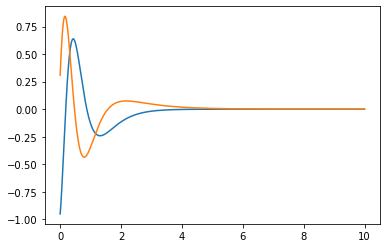

In [100]:
fig, ax = plt.subplots()
ax.plot(*mk_decaying_oscillator2(1.2, tau=1.0, T=T, dt=dt))

In [31]:
def mk_encs(n, d, rng=np.random):
    encs = rng.normal(0, 1, (n, d))
    encs /= np.linalg.norm(encs, axis=1)[:, None]
    return encs

In [225]:
n_neurons = 100
n_temporal_dimensions = 2
n_dimensions = 1

#gains, biases, _ = nonneg_common.mk_ensemble(n_neurons, d=1)
gains = np.ones(n_neurons) * 3
biases = np.ones(n_neurons)
G = lif_utils.lif_rate
TEs = mk_encs(n_neurons, n_temporal_dimensions)
idcs = np.argsort(np.arctan2(TEs[:, 1], TEs[:, 0]), axis=0)
TEs = TEs[idcs]
Es = np.ones((n_neurons, 1))
#Es = mk_encs(n_neurons, n_dimensions)

ts, Ms = mk_decaying_oscillator(3.5, tau=None, T=T, dt=dt)
#ts, Ms = mk_decaying_oscillator(5.0, tau=100e-3, T=T, dt=dt)
#ts, Ms = mk_high_pass(5.0, tau=0.5, T=T, dt=dt)

flts_in = [(100e-3,),]
flts_rec = [(100e-3,),]

In [226]:
np.random.seed(58381)
W_in, W_rec, errs = temporal_encoder_common.solve_for_recurrent_population_weights_with_spatial_encoder(
    G, gains, biases, None, None, TEs, Es,
    [Filters.lowpass(*flt_in) for flt_in in flts_in],
    [Filters.lowpass(*flt_rec) for flt_rec in flts_rec],
    Ms=Ms,
    N_smpls=1000,
    xs_sigma=3.0,
    biased=False,
    dt=dt)

100%|██████████| 100/100 [00:01<00:00, 98.59it/s]


In [227]:
errs

array([0.02702981, 0.02700066, 0.02697592, 0.0265203 , 0.02650197,
       0.02630237, 0.02618127, 0.02615718, 0.02616611, 0.02623826,
       0.02626349, 0.02629218, 0.02635976, 0.02637451, 0.02702859,
       0.02706828, 0.02732315, 0.02745027, 0.02755889, 0.02764987,
       0.02809651, 0.02821739, 0.02839203, 0.02872884, 0.02876021,
       0.02878767, 0.02886018, 0.02887524, 0.02894223, 0.02910185,
       0.0291135 , 0.02911385, 0.02907214, 0.02898812, 0.02894794,
       0.02848523, 0.02845159, 0.02828853, 0.02816498, 0.02757072,
       0.02732997, 0.02716932, 0.02708799, 0.02693663, 0.0268936 ,
       0.02653604, 0.02648517, 0.02626353, 0.02623726, 0.02619895,
       0.02616785, 0.02616397, 0.02616238, 0.02614816, 0.02614934,
       0.02614981, 0.0261698 , 0.02619622, 0.02621106, 0.02643274,
       0.02674904, 0.02706239, 0.02706867, 0.02717294, 0.02728331,
       0.02738756, 0.02740236, 0.02749776, 0.0281074 , 0.02818904,
       0.02846258, 0.02870904, 0.02872147, 0.02899521, 0.02907

In [228]:
np.random.seed(498184)

def execute_network(xs,
                    W_in,
                    W_rec,
                    gains,
                    biases,
                    T=10.0,
                    dt=1e-4,
                    tau=100e-3):
    N = int(T / dt + 1e-9)
    n_dims = n_dimensions
    n_neurons = len(gains)

    with nengo.Network() as model:
        nd_in = nengo.Node(size_in=n_dims)
        for i in range(n_dims):
            #nd_noise = nengo.Node(nengo.processes.WhiteSignal(period=10.0, high=10.0, y0=0.0, rms=10.0))
            nd_noise = nengo.Node(lambda t: 20.0 * np.logical_and(t >= 0.1, t <= 0.2))
            nengo.Connection(nd_noise, nd_in[i], synapse=None)

        ens_x = nengo.Ensemble(n_neurons=n_neurons,
                               dimensions=n_temporal_dimensions,
                               bias=biases,
                               gain=gains,
                               encoders=TEs)

        nengo.Connection(nd_in,
                         ens_x.neurons,
                         transform=W_in[:, :, 0],
                         synapse=tau)

        nengo.Connection(ens_x.neurons,
                         ens_x.neurons,
                         transform=W_rec[:, :, 0],
                         synapse=tau)

        p_in = nengo.Probe(nd_in, synapse=None)
        p_out = nengo.Probe(ens_x.neurons, synapse=None)
        p_out_v = nengo.Probe(ens_x.neurons, 'voltage', synapse=None)

    with nengo.Simulator(model, dt=dt) as sim:
        sim.run(T)

    return sim.trange(), sim.data[p_in], sim.data[p_out], sim.data[p_out_v]

ts, xs, As, As_v = execute_network(None, W_in, W_rec, gains, biases)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

(0.0, 10.0)

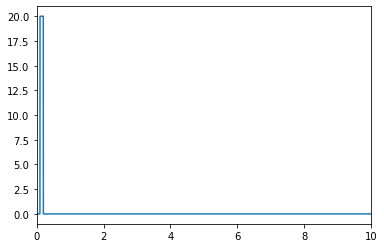

In [229]:
fig, ax = plt.subplots()
ax.plot(ts, xs)
ax.set_xlim(0, 10)

(0.0, 5.0)

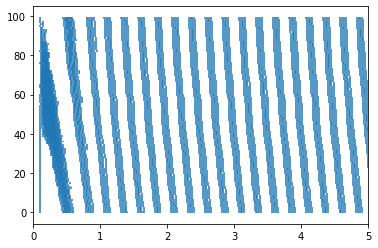

In [230]:
fig, ax = plt.subplots()
ax.eventplot([np.where(As[:, i])[0] * 1e-4 for i in range(n_neurons)]);
ax.set_xlim(0, 5)

(2.0, 5.0)

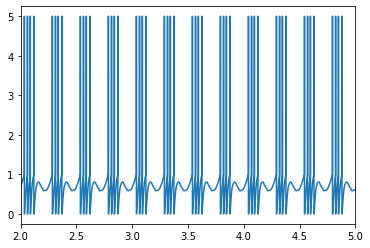

In [231]:
fig, ax = plt.subplots()
ax.plot(ts, np.clip(As_v + As, None, 5)[:, 10])
ax.set_xlim(2, 5)